In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext import data
from sklearn.metrics import confusion_matrix,f1_score
import matplotlib.pyplot 
import randomas plt
import seaborn as sns
from sklearn.metrics import  classification_report

In [ ]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
def generate_bigrams(x):
  n_grams = set(zip(*[x[i:] for i in range(2)]))
  for n_gram in n_grams:
    x.append(" ".join(n_gram))
  return x

In [ ]:
TEXT = data.Field(tokenize="spacy",include_lengths=True)
LABEL = data.LabelField()
fields = [(None,None),('text', TEXT),('label',LABEL), (None,None)]

In [ ]:
train_data, test_data = data.TabularDataset.splits(
                                        path = '/content/drive/MyDrive/data/benchmarking_data',
                                        train = 'train.csv',
                                        test = 'valid.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [ ]:

train_data,valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
MAX_VOCAB_SIZE = 25_000
 
TEXT.build_vocab(train_data,max_size=MAX_VOCAB_SIZE,
                 vectors="glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399178/400000 [00:18<00:00, 20372.99it/s]

In [ ]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dl,valid_dl,test_dl = data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True,
    sort_key=lambda x:len(x.text)
)

In [ ]:
class LSTM(nn.Module):
  def __init__(self,input_dim,embedding_dim,hidden_dim,output_dim,n_layers,
               bidirectional,dropout):
    super().__init__()

    self.embedding =  nn.Embedding(input_dim,embedding_dim)

    self.lstm = nn.LSTM(embedding_dim,hidden_dim,num_layers=n_layers,
                        bidirectional=bidirectional,
                        dropout=dropout)
    
    self.fc = nn.Linear(hidden_dim*2,output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self,text,text_lengths):
    #text = [sent_len,batch_size]
    embedded = self.dropout(self.embedding(text))
    #embedded = [sent_len,batch_size,emb_dim]
    #pack sequence
    packed_embedded =  nn.utils.rnn.pack_padded_sequence(embedded,text_lengths)

    packed_output, (hidden,cell) = self.lstm(packed_embedded)
    #unpack sentence
    output,output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    #output = [sent len, batch size, hid dim * num directions]
    #output over padding tokens are zero tensors
    #hidden = [num layers * num directions, batch size, hid dim]
    #cell = [num layers * num directions, batch size, hid dim]
        
    #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and apply dropout

    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

    #hidden = [batch_size,hid_dim*num_directions]

    return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 3,379,135 trainable parameters


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def accuracy(y_pred,y):
  """
  Returns a accuracy score
  """
  max_preds = y_pred.argmax(dim=1,keepdim=True)
  correct = max_preds.squeeze(1).eq(y)
  return correct.sum()/torch.FloatTensor([y.shape[0]])

In [ ]:
#train the model
def train(model,iterator,optimizer,criterion):
  epoch_loss = 0
  epoch_acc = 0
 
  model.train()

  for batch in iterator:

    optimizer.zero_grad()

    text,text_lengths = batch.text

    predictions = model(text,text_lengths)

    loss = criterion(predictions,batch.label)

    acc = accuracy(predictions,batch.label)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [ ]:
def evaluate(model,iterator,criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for batch in iterator:

      text,text_lengths = batch.text

      predictions = model(text,text_lengths)

      loss = criterion(predictions,batch.label)

      acc = accuracy(predictions,batch.label)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_dl, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Models/INTENT/lstm-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 0.545 | Train Acc: 82.96%
	 Val. Loss: 0.166 |  Val. Acc: 94.62%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 0.195 | Train Acc: 93.86%
	 Val. Loss: 0.097 |  Val. Acc: 96.98%
Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.137 | Train Acc: 95.48%
	 Val. Loss: 0.086 |  Val. Acc: 97.48%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.110 | Train Acc: 96.47%
	 Val. Loss: 0.075 |  Val. Acc: 97.61%
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.086 | Train Acc: 97.42%
	 Val. Loss: 0.078 |  Val. Acc: 97.99%


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    B = (C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]

In [ ]:
def get_predictions(model,iterator):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for batch in iterator:

      text,text_lengths = batch.text

      predictions = model(text,text_lengths)

      y_pred.extend(torch.argmax(predictions,axis=-1).tolist())
      y_true.extend(batch.label.tolist())

  return y_pred,y_true

In [ ]:
y_pred,y_true = get_predictions(model,test_dl)

-------------------- Confusion matrix --------------------


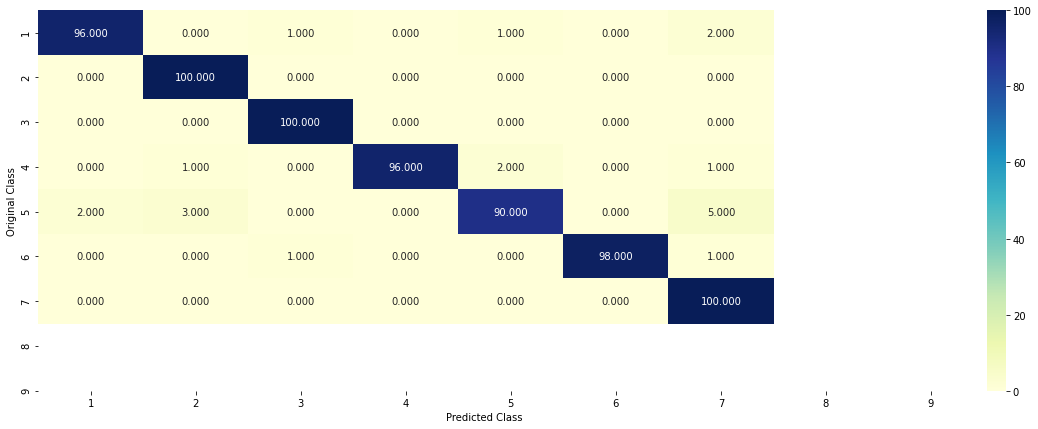

-------------------- Precision matrix (Columm Sum=1) --------------------


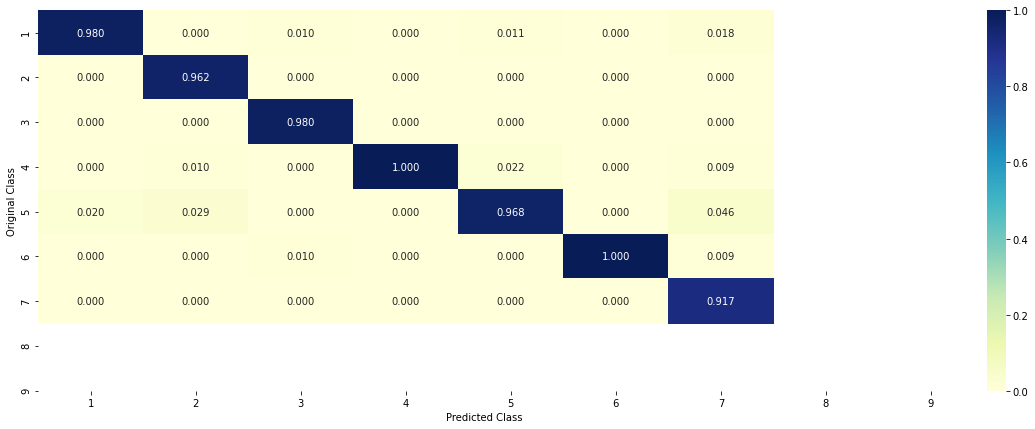

-------------------- Recall matrix (Row sum=1) --------------------


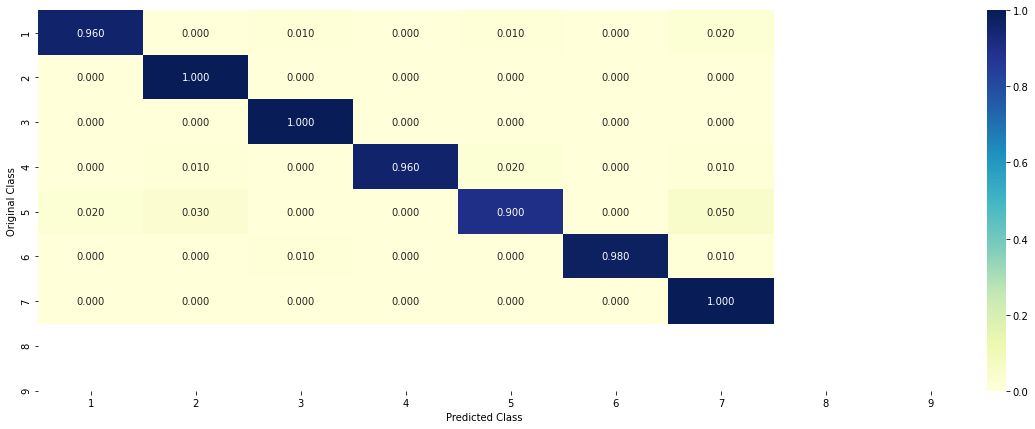

In [ ]:
plot_confusion_matrix(y_true,y_pred)

In [ ]:
print('Classification Report:')
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       100
           1       0.96      1.00      0.98       100
           2       0.98      1.00      0.99       100
           3       1.00      0.96      0.98       100
           4       0.97      0.90      0.93       100
           5       1.00      0.98      0.99       100
           6       0.92      1.00      0.96       100

    accuracy                           0.97       700
   macro avg       0.97      0.97      0.97       700
weighted avg       0.97      0.97      0.97       700

